In [1]:
library(tidyverse)
library(cowplot)
library(scales)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [2]:
eval_df <- read_tsv('../data/fst/multi_metric_bootstrap_evaluation.tsv')

eval_df %>% head(2)

Parsed with column specification:
cols(
  phenotype = col_character(),
  threshold = col_double(),
  distance_metric = col_character(),
  distance_group = col_double(),
  distance_group_mean = col_double(),
  incremental_r2 = col_double(),
  bootstrap_iter = col_character(),
  bootstrap_incremental_r2 = col_double(),
  conf.lower = col_double(),
  conf.upper = col_double()
)



phenotype,threshold,distance_metric,distance_group,distance_group_mean,incremental_r2,bootstrap_iter,bootstrap_incremental_r2,conf.lower,conf.upper
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Basophil,0,fst,5,0.1294594,0.001729775,Bootstrap01,0.003045868,0.0006508898,0.003068478
Basophil,0,fst,5,0.1294594,0.001729775,Bootstrap02,0.001498795,0.0006508898,0.003068478


In [5]:
eval_df %>% distinct(distance_metric)

distance_metric
<chr>
fst
manhattan_20
euclidean_20
ibs
ibd


In [6]:
summary_plot_df <- eval_df %>% 
    select(-starts_with('bootstrap')) %>%
    distinct() %>%
    group_by(phenotype, distance_metric, distance_group) %>%
    top_n(1, incremental_r2) %>%
    ungroup

# Order phenotypes uniformly
orderings <- summary_plot_df %>%
    group_by(phenotype) %>%
    summarize(
        order = max(incremental_r2 * (distance_metric == 'fst' & distance_group == 1))
    ) %>%
    ungroup %>%
    arrange(desc(order)) %>%
    mutate(color = hue_pal()(n()))

phenotype_orders <- orderings %>% pull(phenotype)
colors <- split(orderings$color, orderings$phenotype) %>% as_vector

summary_plot_df <- summary_plot_df %>%
    mutate(
        phenotype = phenotype %>% fct_relevel(phenotype_orders),
        distance_metric = distance_metric %>% fct_relevel(c('fst', 'manhattan_20', 'euclidean_20',
                                                            'ibs', 'ibd')),
        distance_label = distance_metric %>% recode_factor(
            'fst' = 'F[ST]', 'manhattan_20' = 'PC~`1-norm`', 'euclidean_20' = 'PC~`2-norm`', 
            'ibs' = 'IBS', 'ibd' = 'IBD')
    )

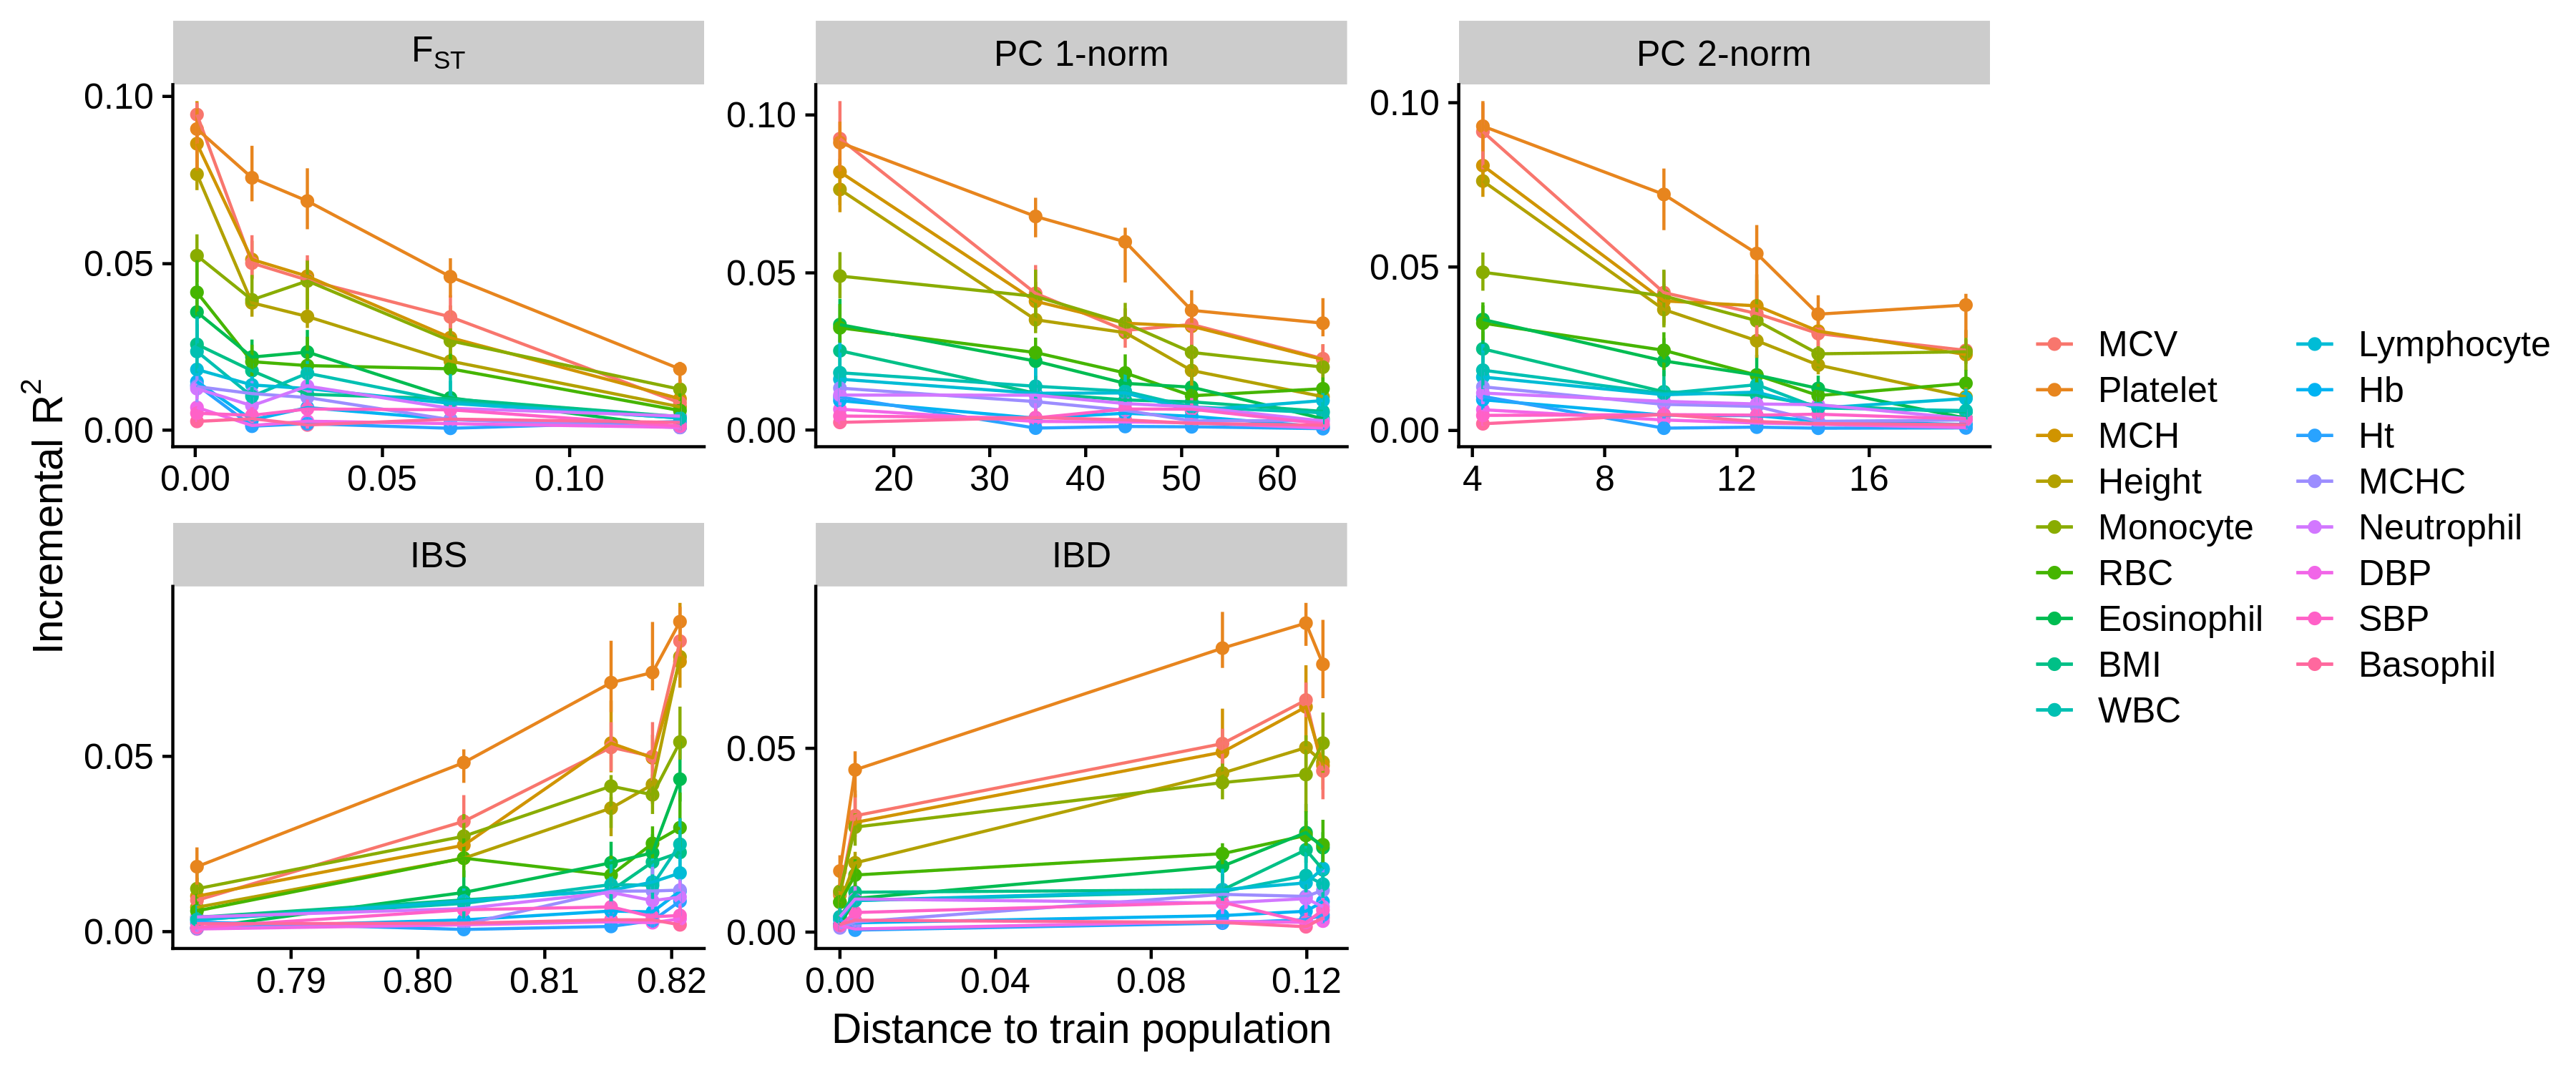

In [9]:
overall_plot <- summary_plot_df %>%
    filter(distance_metric %in% c('fst', 'euclidean_20', 'manhattan_20', 
                                  'ibs', 'ibd')) %>%
    ggplot(aes(x = distance_group_mean, y = incremental_r2, group = phenotype, 
               color = phenotype, ymin = conf.lower, ymax = conf.upper)) +
    geom_point() +
    geom_errorbar(width = 0) +
    geom_line() + 
    xlab('Distance to train population') +
    ylab(expression("Incremental"~R^2)) +
    facet_wrap(vars(distance_label), scales = 'free', 
               labeller = label_parsed) +
    theme_cowplot() +
    guides(color = guide_legend(ncol = 2)) +
    theme(
        legend.title = element_blank()
    ) +
    scale_color_manual(values = colors) +
    scale_y_continuous(trans = 'atanh', n.breaks = 3)

options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 300)

overall_plot